In [69]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import statsmodels.formula.api as smf

# Data Pipeline

## How datasets are joined

### Movie dataset and Character dataset
We join the two datasets on the `freebase_movie_id`.

### Character dataset and Oscar dataset
Oscar dataset does not have `freebase_movie_id` or `freebase_actor_id`. We instead use `parsed_actor_name` and `movie_identifier`. `parsed_actor_name` will be unique for each movie as we drop actors if they share `parsed_actor_name` from playing another character in the same movie. `movie_identifier` is a combination of `parsed_movie_name` and `release_year`. This is unique as we drop movies that share `movie_identifier`.

### Resulting dataset from previous steps and IMDb dataset
We join these datasets using a combination of `parsed_movie_name` and `release_year` as primary key.
<br><br><br>
The resulting dataset after the entire pipeline is run is written to `cache/data.csv`, ready for use in P3.

In [70]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping
314 movies had actors with the same name, dropping

Merging Oscar dataset, after merge:
Number of different Oscar nominated movies in dataset: 952 in total 63968 different movies
Number of different Oscar nominated actors in dataset: 801 in total 134907 different actors
Number of Oscar nominated rows: 1443

Merging IMDb dataset, after merge:
Number of movies with ratings: 36758
Oscar nominated movies with rating: 939
Processing done, dataset written to cache/data.csv


In [71]:
movie_df = pd.read_csv('cache/data.csv', sep=',', index_col=0)

In [72]:
movie_df.head()

# Country/nomination analysis

In [73]:
# movie_character_oscar_rating_df contains a row for each actor/movie pair. We select the non-American actors and compare with the American actors

# All actors/movie rows, American and non-American
total_actors_num = len(movie_df['countries'])
american_total_actors_num = len(movie_df[movie_df['countries'].str.contains('United States of America')])
non_american_total_actors_num = total_actors_num - american_total_actors_num

# All actors/movie rows with an Oscar nomination, American and non-American
total_nominated_actors_num = len(movie_df[movie_df['oscar_nominated'] == True]['countries'])
american_nominations_num = len(movie_df[(movie_df['countries'].str.contains('United States of America')) & (movie_df['oscar_nominated'] == True)])
non_american_nominations_num = total_nominated_actors_num - american_nominations_num

In [74]:
# Observed probability of American actor getting nominated for a film
p_american = american_nominations_num / american_total_actors_num
p_non_american = non_american_nominations_num / non_american_total_actors_num

# We perform a hypothesis test for whether non-American actors getting nominated have the same binomial probability as American ones
stats.binomtest(non_american_nominations_num, non_american_total_actors_num, p_american)

P-value=2.6118071094409342e-307. We can safely discard the hypothesis that these have the same probability distribution, and conclude that there is a significantly different probability of being nominated for an Oscar for American and non-American actors.

In [75]:
print('Fraction of American actors nominated for an Oscar:',round(p_american, 5))
print('Fraction of non-American actors nominated for an Oscar:', round(p_non_american, 5))

We see that the observed probability of being nominated is higher for actors in American movies. We believe based on this analysis that the Oscar nominations are generally skewed with higher chances for actors in American movies.

# Logistic regression on movie and actor traits

In [76]:
movie_df.columns

In [77]:
# Finding the most common ethnicities
movie_df.groupby('actor_ethnicity').count().sort_values(by='title', ascending=False).head(15)

In [78]:
# top fifteen most frequent ethnicities
# Found the mappings by looking the ids up.
# Not fun :(

# An alternate solution would probably be to download the other freebase datasets and join using that.
# However, the dataset is quite large so we chose to go this route instead.
ethnicity_map = {    
    'Indian' : '/m/0dryh9k',
    'Black' : '/m/0x67',
    'Jewish' : '/m/041rx', 
    'English' : '/m/02w7gg',
    'Irish_Americans' : '/m/033tf_',
    'Italian_Americans' : '/m/0xnvg',
    'White_people' : '/m/02ctzb',
    'White_Americans' : '/m/07hwkr',
    'Scottish_Americans': '/m/07bch9',
    # '???' : '/m/044038p', Could not find what this maps to
    'Irish_people' : '/m/03bkbh',
    'British' : '/m/0d7wh',
    'French' : '/m/03ts0c',
    'Italians' : '/m/0222qb',
    'Tamil' : '/m/01rv7x',   
}

UNUSED_ethnicity_map = {    
    '/m/0dryh9k' : 'Indian',
    '/m/0x67' : 'Black',
    '/m/041rx' : 'Jewish', 
    '/m/02w7gg' : 'English',
    '/m/033tf_' : 'Irish_Americans',
    '/m/0xnvg' : 'Italian_Americans',
    '/m/02ctzb' : 'White_people',
    '/m/07hwkr' : 'White_Americans',
    '/m/07bch9' : 'Scottish_Americans',
    '/m/044038p' : '???', # Could not find what this maps to
    '/m/03bkbh' : 'Irish_people',
    '/m/0d7wh' : 'British',
    '/m/03ts0c' : 'French',
    '/m/0222qb' : 'Italians',
    '/m/01rv7x' : 'Tamil',   
}

In [79]:
# We normalize the data before performing logistic regression

def normalize_column(df_column):
    return (df_column - df_column.mean()) / df_column.std()

normalized_movie_df = movie_df.copy(deep=True)
normalized_movie_df['actor_age'] = normalize_column(normalized_movie_df['actor_age'])
normalized_movie_df['box_office_revenue'] = normalize_column(normalized_movie_df['box_office_revenue'])
normalized_movie_df['runtime'] = normalize_column(normalized_movie_df['runtime'])
normalized_movie_df['actor_height'] = normalize_column(normalized_movie_df['actor_height'])
normalized_movie_df['year'] = normalize_column(normalized_movie_df['year'])
normalized_movie_df['average_rating'] = normalize_column(normalized_movie_df['average_rating'])
normalized_movie_df['number_of_votes'] = normalize_column(normalized_movie_df['number_of_votes'])
normalized_movie_df['oscar_nominated'] = normalized_movie_df['oscar_nominated'].replace({True: 1, False: 0})

# One-hot encoding the 5 most frequent ethnicities for the logistic regression:
ethnicities = ['Indian', 'Black', 'Jewish', 'English', 'Irish_Americans']
for name in ethnicities:
    normalized_movie_df[name] = normalized_movie_df['actor_ethnicity'].map(lambda ethnicity: 1 if ethnicity == ethnicity_map[name] else 0)

In [80]:
# Regression and plotting code inspired and/or copied from solution to exercise 4
# We perform logistic regression using a selection of relevant features from the dataframe
mod = smf.logit(formula='oscar_nominated ~  runtime + box_office_revenue + actor_height + \
                        actor_age + year + average_rating + number_of_votes + \
                        C(Indian) + C(Black) + C(Jewish) + C(English) + C(Irish_Americans)', data=normalized_movie_df)

In [81]:
# Fit the model and print results
res = mod.fit()
print(res.summary())

In [82]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

In [83]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

In [84]:
# Plot the results
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

From this plot we see that there are multiple factors that can be used to predict whether a movie/actor row will be nominated or not. This serves as an initial analysis, we will do this more thoroughly in P3 to make more relevant conclusions for our research questions.

# Review analysis

To extract movies with nominated actors we need to find every movie where atleast one of the rows in the column 'oscar_nominated' is positive.
To extract movies without a nominated actor we need to find every movie where every row in the column 'oscar_nominated' is false. 

In [85]:
# Grouping by title
unique_movies_df = movie_df.groupby('movie_identifier').first().reset_index()
print('Shape before: ', unique_movies_df.shape)
unique_nominated_movies_df = movie_df[movie_df['oscar_nominated'] == True].groupby('movie_identifier').first().reset_index()
# Mask is true if a movie from unique_movies_df is not in the dataframe unique_nominated_movies_df
mask = unique_movies_df['movie_identifier'].isin(unique_nominated_movies_df['movie_identifier']) == False
# Applying the mask 
not_nominated_df = unique_movies_df[mask]

# Checking the intersection between nominated and not nominated movies, should be 0 
print('Intersection: ', pd.Series(list(set(unique_nominated_movies_df['movie_identifier']).intersection(set(not_nominated_df['movie_identifier'])))))

unique_movies_df = pd.concat([unique_nominated_movies_df, not_nominated_df], axis = 0) 
print('Shape after: ', unique_movies_df.shape)

In [86]:
# Removing movies without imdb ratings
movie_unique_with_rating_df = unique_movies_df[unique_movies_df['average_rating'].notna()]


In [87]:
# Extracting nominated and movies and not nominated movies 
nominated = movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated']]
not_nominated = movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated'] == False]
assert nominated.shape[0] + not_nominated.shape[0] == movie_unique_with_rating_df.shape[0]

In [88]:
# We exclude all movies with fewer than 30 reviews. There are no movies with oscar nominated actors with fewer than 30 reviews.
# This is based on a rule of thumb to exlude outliers / low confidence values 
excluded = not_nominated[not_nominated['number_of_votes'] < 30]
print('Excluded: ', len(excluded))
not_nominated = not_nominated[not_nominated['number_of_votes'] > 30]
nominated = nominated[nominated['number_of_votes'] > 30]

In [89]:
# Empirical CDF for nominated and not nominated 

sns.histplot(nominated, x="average_rating", stat = 'density', color = 'gold',label ='Nominated')
sns.histplot(not_nominated, x="average_rating", stat="density", color = 'grey', label = 'Not nominated')

plt.title('Rating distribution of movies')
plt.xlabel('IMDB rating')
plt.ylabel('Probability density')
plt.legend()
plt.show()


These empirical distributions look different. We use a two sample Kolmogorov-Smirnov test to test if they are different. The null hypothesis is that the observations come from the same distribution. We reject the null hypothesis if the p-value < 0.05.

In [22]:
stats.kstest(nominated['average_rating'], not_nominated['average_rating'])

KstestResult(statistic=0.548767896599537, pvalue=9.133861546879403e-258, statistic_location=6.8, statistic_sign=-1)

P-value = 1.0389776134332205e-255. This is small enough to safely reject the null hypothesis. We conclude that the distributions are in fact different distributions. 

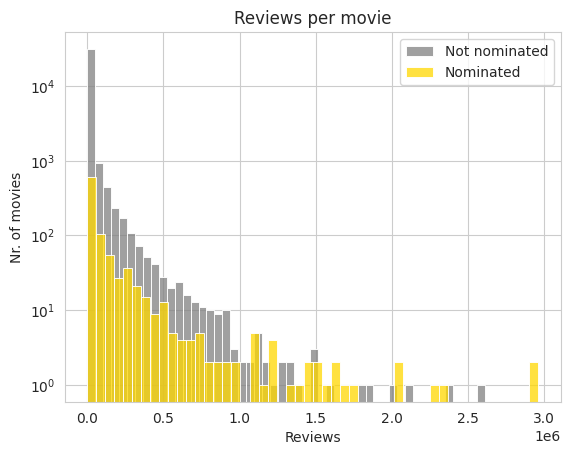

In [23]:
# Plotting reviews per IMDB reviews per movie 
sns.histplot(not_nominated, x="number_of_votes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(nominated, x="number_of_votes", bins=50, label = 'Nominated', color = 'gold')
plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies')
plt.legend()
plt.show()

Share of not nominated movies with fewer than 10 000 reviews 82.67 %
Share of nominated with fewer than 10 000 reviews 33.55 %


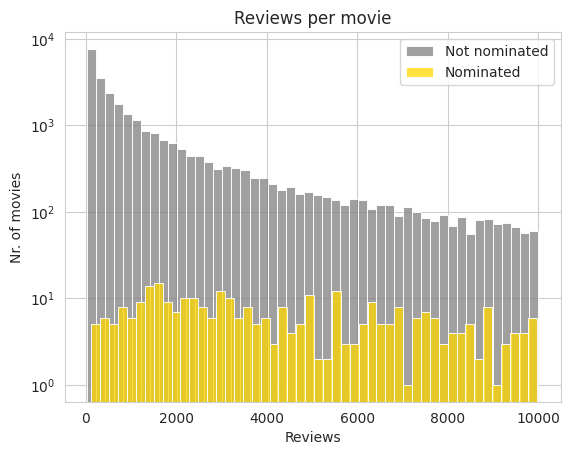

In [24]:
# As per the plot above, most movies with nominated actors have fewer than 500 000 reviews.
# We zoom in and look at the movies with few reviews. 

lim_not_nominated = not_nominated[not_nominated['number_of_votes'] < 10000]
lim_nominated = nominated[nominated['number_of_votes'] < 10000]

print('Share of not nominated movies with fewer than 10 000 reviews', round(len(lim_not_nominated)/len(not_nominated)*100,2), '%')
print('Share of nominated with fewer than 10 000 reviews', round(len(lim_nominated)/(len(nominated))*100,2),  '%')

sns.histplot(lim_not_nominated, x="number_of_votes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(lim_nominated, x="number_of_votes", bins=50, label = 'Nominated', color = 'gold')

plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies')
plt.legend()
plt.show()

We can see that most movies with relatively few review are not nominated. 

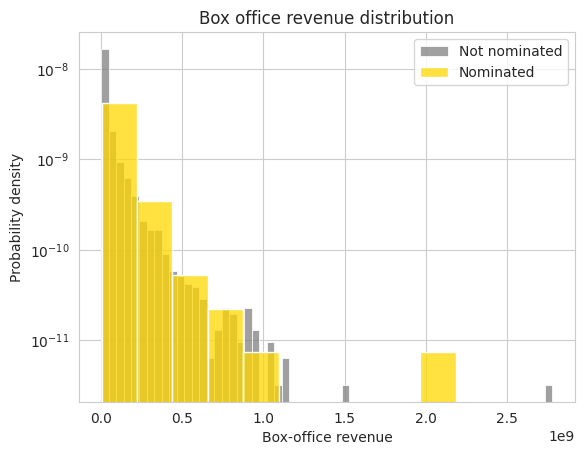

In [25]:
sns.histplot(not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated', bins = 60)
sns.histplot(nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated', bins = 10)

plt.title('Box office revenue distribution')
plt.yscale('log')
plt.xlabel('Box-office revenue')
plt.ylabel('Probability density')
plt.legend()
plt.show()

Notice that the above plot is a probability distribution and that the y axis is in log scale. We are suprised since all movies with nominated actors does not seem to be the ones with the highest revenue. To investigate this we look into movies with lower box-office revenue. 

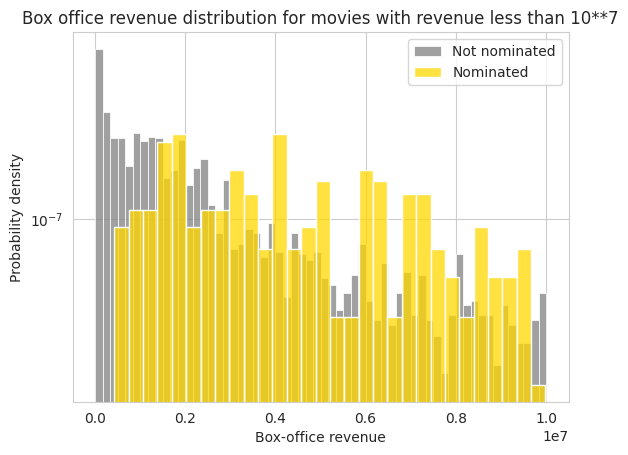

In [26]:
lim_not_nominated = not_nominated[not_nominated['box_office_revenue'] < 10**7]
lim_nominated = nominated[nominated['box_office_revenue'] < 10**7]

sns.histplot(lim_not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated', bins = 60)
sns.histplot(lim_nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated', bins = 30)

plt.title('Box office revenue distribution for movies with revenue less than 10**7')
plt.yscale('log')
plt.xlabel('Box-office revenue')
plt.ylabel('Probability density')
plt.legend()
plt.show()


We can see that movies with nominated actors have revenue in an interval. They neither the movies with the highest revenue, or the movies with the lowest revenue. 

In [27]:
nominated = movie_df[movie_df['oscar_nominated'] == True]
nominated['movie_identifier'].value_counts()

movie_identifier
on the waterfront_1954        5
bonnie and clyde_1967         5
all about eve_1950            5
the godfather part ii_1974    5
network_1976                  5
                             ..
black swan_2010               1
cinderella man_2005           1
ghost_1990                    1
the cider house rules_1999    1
juno_2007                     1
Name: count, Length: 952, dtype: int64

In [28]:
oscar_nomination_count_per_movie = nominated.groupby(["movie_identifier"])['movie_identifier'].count().to_frame().rename(columns={"movie_identifier": "count"})

<Axes: xlabel='count', ylabel='Density'>

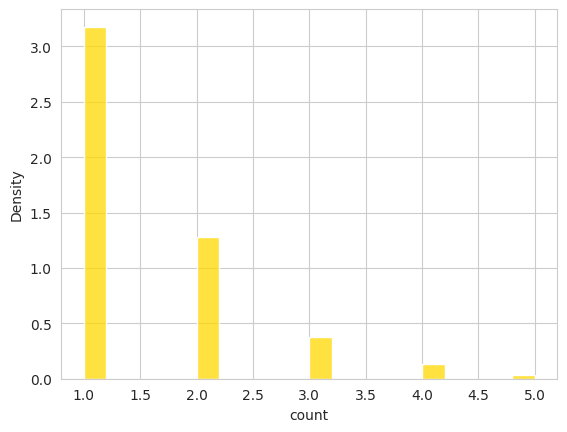

In [29]:
sns.histplot(oscar_nomination_count_per_movie, x="count", stat = 'density', color = 'gold',label ='Nominated')


In [30]:
# Defining some variables for analysis. 
nr_movies = len(unique_movies_df)
nr_nom_movies = len(nominated.groupby('movie_identifier'))
nr_nominations = len(nominated)

zero_nom_movies = nr_movies - nr_nom_movies
one_nom_movies = len(oscar_nomination_count_per_movie[oscar_nomination_count_per_movie['count'] == 1])

In [31]:
# What is the probablity a movie will have a nominated actor? 
print('Likelyhood of a movie having a nominated actor: ', round(nr_nom_movies/nr_movies*100, 3), '%')

# Given that a movie has a nominated actor, what is the probablity that it will have atleast one more nominated actor? 
print('Probablity that a movie with a nominated actor will have atleast one more nominated actor', round((nr_nom_movies - one_nom_movies)/(nr_nom_movies)*100, 3), '%')


Likelyhood of a movie having a nominated actor:  1.488 %
Probablity that a movie with a nominated actor will have atleast one more nominated actor 36.45 %


<Axes: xlabel='count', ylabel='Density'>

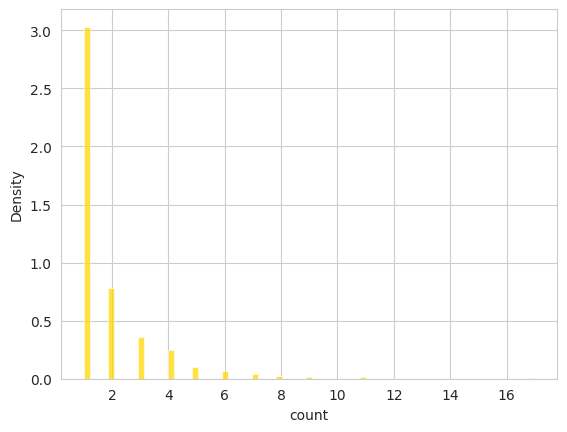

In [32]:
oscar_nomination_per_actor_name = nominated.groupby(["actor_identifier"])['actor_identifier'].count().to_frame().rename(columns={"actor_identifier": "count"})
sns.histplot(oscar_nomination_per_actor_name, x="count", stat = 'density', color = 'gold',label ='Nominated')
